In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiFBvJHQUtfA4FxpKSABIpVmuXUdV_Khmu_4zaMe6lz4DY9lQBuYcM
Mounted at /content/gdrive


In [2]:
#importing some important libraries
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
SEED = 42    
seed_everything(SEED)

In [4]:
#Load files into a pandas dataframe
train = pd.read_csv('/content/gdrive/My Drive/INSURANCE_DATA/Train_5.csv')
test = pd.read_csv('/content/gdrive/My Drive/INSURANCE_DATA/Test_5.csv')
ss = pd.read_csv('/content/gdrive/My Drive/INSURANCE_DATA/SampleSubmission_5.csv')

In [5]:
#view the first 5 rows of the train dataset
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [6]:
#view the first 5 rows of the train dataset
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [7]:
test.shape

(1202, 13)

In [8]:
train.shape

(12079, 14)

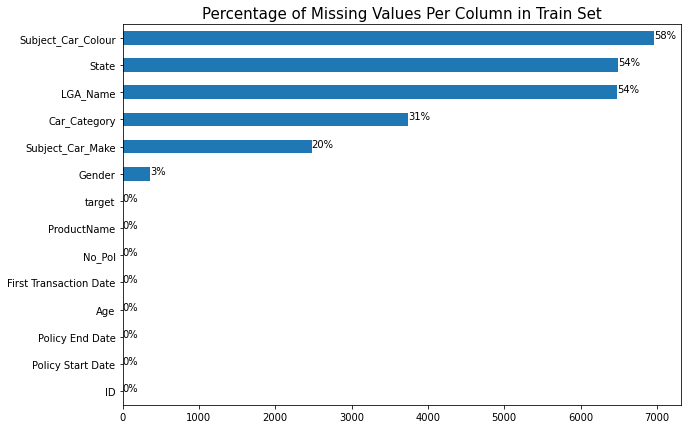

In [9]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

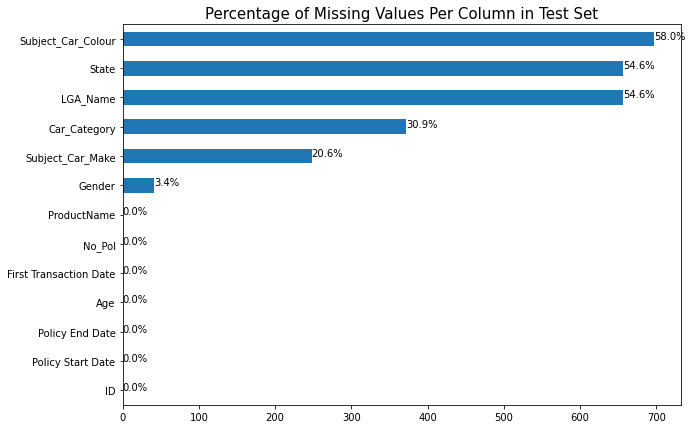

In [10]:
#Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [11]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [12]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [13]:
all_data['Car_Category'].value_counts()

Saloon                     6633
JEEP                       2223
Truck                       108
Bus                          56
Mini Bus                     45
Pick Up                      32
Motorcycle                   18
Sedan                        14
Mini Van                     13
Wagon                        10
Shape Of Vehicle Chasis       6
Station 4 Wheel               6
Van                           3
Pick Up > 3 Tons              2
Tipper Truck                  1
CAMRY CAR HIRE                1
Name: Car_Category, dtype: int64

In [14]:
#regrouping the car category
mapper = {'Bus':'other', 'Mini Bus':'other', 'Pick Up':'other', 'Motorcycle':'other', 'Sedan':'other', 'Mini Van':'other', 'Wagon':'other', 'Shape Of Vehicle Chasis':'other',
          'Station 4 Wheel':'other', 'Van':'other', 'Pick Up > 3 Tons':'other', 'CAMRY CAR HIRE':'other', 'CAMRY CAR HIRE':'other', 'Tipper Truck':'Truck'}
all_data.Car_Category = all_data.Car_Category.replace(mapper)


In [15]:
all_data['Subject_Car_Colour'].value_counts().head(60)

Black             2057
Silver             605
Grey               565
As Attached        555
Blue               398
White              321
Red                274
Green              259
Gold               192
Ash                142
Wine               101
Brown               65
Cream               10
Yellow               8
Dark Gray            7
Orange               5
White & Blue         5
Purple               4
B.Silver             4
Red & White          4
Blue & Red           3
Dark Grey            3
D. Red               3
Light Green          3
Red & Black          2
Black & Orange       2
Gray & Silver        2
Black & White        2
Dark Blue            2
White & Red          2
Gray & Gray          2
Dark Green           1
Red & Blue           1
Beige Mitalic        1
Blue Sky             1
White & Yellow       1
Blue&White&Red       1
Burgundy             1
Light Blue           1
Light Gray           1
Red Maroon           1
Champagne            1
Red & Yellow         1
Dark Red   

In [17]:
#regrouping the Subject_car_colour
mapper = {'Light Gray':'other', 'Beige Mitalic':'other', 'Dark Green':'other', 'Blue Sky':'other', 'Dark Red':'other', 'Champagne':'other', 'Light Blue':'other',
          'Red & Blue':'other', 'White & Yellow' : 'other', 'Yellow & White':'other', 'Red & Yellow':'other', 'Blue&White&Red':'other', 'D. Gold':'other', 
          'Burgundy':'other', 'Red Maroon':'other', 'Dark Blue':'other', 'White & Red':'other', 'Red & Black':'other', 'Black & Orange':'other', 'Black & White':'other',
          'Gray & Silver':'other', 'Gray & Gray':'other', 'D. Red':'other', 'Light Green':'other', 'Dark Grey':'other', 'Blue & Red':'other', 'Purple':'other',
          'B.Silver':'other', 'Red & White':'other', 'White & Blue':'other', 'Dark Gray':'other', 'Yellow':'other', 'Cream':'other', 'other':'other',
          'Brown':'other', 'Orange':'other'}

all_data.Subject_Car_Colour = all_data.Subject_Car_Colour.replace(mapper)
      

In [18]:
all_data['Subject_Car_Make'].value_counts()

TOYOTA           5466
Honda            1146
Lexus             654
Mercedes          577
Hyundai           512
                 ... 
Rols Royce          1
Bajaj               1
Ashok Leyland       1
BRILLIANCE          1
Datsun              1
Name: Subject_Car_Make, Length: 75, dtype: int64

In [20]:
#regrouping the Subject_car_make
mapper = {'Volvo':'other', 'Mack':'other', 'Audi':'other', 'Infiniti':'other', 'Pontiac':'other', 'Chevrolet':'other', 'DAF':'other', 'Skoda':'other', 'Jeep':'other',
          'Porsche':'other', 'As Attached':'other','Scania':'other', 'Man':'other', 'GAC':'other', 'MINI COOPER':'other', 'Land Rover.':'other', 'GMC':'other',
          'Subaru':'other', 'Renault':'other', 'Dodge':'other', 'Isuzu':'other', 'Opel':'other', 'Suzuki':'other', 'Mazda':'other', 'Peugeot':'other', 'other':'other',
          'CHANGAN':'other', 'Grand Cherokee':'other', 'Fiat':'other', 'Astra':'other', 'Black':'other', 'Hummer':'other', 'Chrysler':'other', 'Innson':'other',
          'Seat':'other', 'Wrangler Jeep':'other', 'FOTON':'other', 'Jaguar':'other', 'LIBERTY':'other', 'other':'other', 'Caddillac':'other', 'BRILLIANCE':'other',
          'Datsun':'other', 'Ashok Leyland':'other', 'Raston':'other', 'MG':'other', 'COMMANDER':'other', 'KA':'other', 'ABG':'other', 'Buik':'other', 'Jincheng':'other',
          'REXTON':'other','Bajaj':'other', 'other':'other', 'ZOYTE':'other', 'Motorcycle':'other', 'Yamaha':'other', 'Lincoln':'other', 'Howo':'other', 'Geely':'other',
          'Tata':'other', 'Rols Royce':'other', 'other':'other', '.':'other', 'Land Rover':'other', 'BMW':'other', 'ACURA':'other', 'other':'other'}
all_data.Subject_Car_Make = all_data.Subject_Car_Make.replace(mapper)          

In [21]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [23]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

In [24]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  #elif col in num_cols:
    #all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                       0
Car_Category              0
First Transaction Date    0
Gender                    0
ID                        0
LGA_Name                  0
No_Pol                    0
Policy End Date           0
Policy Start Date         0
ProductName               0
State                     0
Subject_Car_Colour        0
Subject_Car_Make          0
dtype: int64

In [25]:
#statistics summary of the numeric variables
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,13281.0,42.375574,93.170951,-6099.0,35.0,41.0,50.0,320.0
No_Pol,13281.0,1.302763,0.723195,1.0,1.0,1.0,1.0,10.0
target,12079.0,0.120457,0.325509,0.0,0.0,0.0,0.0,1.0


In [26]:
#setting the age values to the range of 18-100 years
all_data.Age.loc[(all_data.Age < 18) | (all_data.Age > 100)] = np.nan

In [27]:
all_data.Age

0        30.0
1        79.0
2        43.0
3         NaN
4        20.0
         ... 
13276    67.0
13277    43.0
13278    30.0
13279    44.0
13280    28.0
Name: Age, Length: 13281, dtype: float64

In [28]:
from sklearn.impute import SimpleImputer 

# missing values - numeric - impute with mean in column age
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imputer = mean_imputer.fit(all_data[['Age']])
all_data['Age'] = mean_imputer.transform(all_data[['Age']]).ravel()

In [29]:
all_data.Age

0        30.000000
1        79.000000
2        43.000000
3        42.919739
4        20.000000
           ...    
13276    67.000000
13277    43.000000
13278    30.000000
13279    44.000000
13280    28.000000
Name: Age, Length: 13281, dtype: float64

In [30]:
date_cols

['Policy Start Date', 'Policy End Date', 'First Transaction Date']

In [31]:
#converting the date_cols to datetime type
for feat in date_cols:
  all_data[feat] = pd.to_datetime(all_data[feat])

In [32]:
#feature engineering: creating different columns from date columns
all_data['Policy Start Date_year'] = all_data['Policy Start Date'].dt.year
all_data['Policy Start Date_month'] = all_data['Policy Start Date'].dt.month
all_data['Policy Start Date_week'] = all_data['Policy Start Date'].dt.week
all_data['Policy Start Date_day'] = all_data['Policy Start Date'].dt.day
all_data['Policy Start Date_hour'] = all_data['Policy Start Date'].dt.hour
all_data['Policy Start Date_minute'] = all_data['Policy Start Date'].dt.minute
all_data['Policy Start Date_dayofweek'] = all_data['Policy Start Date'].dt.dayofweek
all_data['Policy Start Date_quarter'] = all_data['Policy Start Date'].dt.quarter
all_data['policy Start Date_is_month_start'] = all_data['Policy Start Date'].dt.is_month_start
all_data['Policy Start Date_is_month_end'] = all_data['Policy Start Date'].dt.is_month_end
all_data['Policy Start Date_year_is_year_start'] = all_data['Policy Start Date'].dt.is_year_start
all_data['Policy Start Date_year_is_year_end'] = all_data['Policy Start Date'].dt.is_year_end
all_data['Policy Start Date_year_days'] = all_data['Policy Start Date'].dt.days_in_month
all_data['Policy Start Date_year_is_quarter_start'] = all_data['Policy Start Date'].dt.is_quarter_start
all_data['Policy Start Date_year_is_quarter_end'] = all_data['Policy Start Date'].dt.is_quarter_end
all_data['Policy Start Date_leapyear'] = all_data['Policy Start Date'].dt.is_leap_year





all_data['Policy End Date_year'] = all_data['Policy End Date'].dt.year
all_data['Policy End Date_month'] = all_data['Policy End Date'].dt.month
all_data['Policy End Date_week'] = all_data['Policy End Date'].dt.week
all_data['Policy End Date_day'] = all_data['Policy End Date'].dt.day
all_data['Policy End Date_hour'] = all_data['Policy End Date'].dt.hour
all_data['Policy End Date_minute'] = all_data['Policy End Date'].dt.minute
all_data['Policy End Date_dayofweek'] = all_data['Policy End Date'].dt.dayofweek
all_data['Policy End Date_quarter'] = all_data['Policy End Date'].dt.quarter
all_data['Policy End Date_is_month_start'] = all_data['Policy End Date'].dt.is_month_start
all_data['Policy End Date_is_month_end'] = all_data['Policy End Date'].dt.is_month_end
all_data['Policy End Date_is_year_start'] = all_data['Policy End Date'].dt.is_year_start
all_data['Policy End Date_is_year_end'] = all_data['Policy End Date'].dt.is_year_end
all_data['Policy End Date_days'] = all_data['Policy End Date'].dt.days_in_month
all_data['Policy End Date_is_quarter_start'] = all_data['Policy End Date'].dt.is_quarter_start
all_data['Policy End Date_is_quarter_end'] = all_data['Policy End Date'].dt.is_quarter_end
all_data['Policy End Date_is_leap_year'] = all_data['Policy End Date'].dt.is_leap_year


all_data['First Transaction Date_year'] = all_data['First Transaction Date'].dt.year
all_data['First Transaction Date_month'] = all_data['First Transaction Date'].dt.month
all_data['First Transaction Date_week'] = all_data['First Transaction Date'].dt.week
all_data['First Transaction Date_day'] = all_data['First Transaction Date'].dt.day
all_data['First Transaction Date_hour'] = all_data['First Transaction Date'].dt.hour
all_data['First Transaction Date_minute'] = all_data['First Transaction Date'].dt.minute
all_data['First Transaction Date_dayofweek'] = all_data['First Transaction Date'].dt.dayofweek
all_data['First Transaction Date_quarter'] = all_data['First Transaction Date'].dt.quarter
all_data['First Transaction Date.is_month_start'] = all_data['First Transaction Date'].dt.is_month_start
all_data['First Transaction Date_is_month_end'] = all_data['First Transaction Date'].dt.is_month_end
all_data['First Transaction Date_is_year_start'] = all_data['First Transaction Date'].dt.is_year_start
all_data['First Transaction Date_is_year_end'] = all_data['First Transaction Date'].dt.is_year_end
all_data['First Transaction Date_days'] = all_data['First Transaction Date'].dt.days_in_month
all_data['First Transaction Date_is_quarter_start'] = all_data['First Transaction Date'].dt.is_quarter_start
all_data['First Transaction Date_is_quarter_end'] = all_data['First Transaction Date'].dt.is_quarter_end
all_data['First Transaction Date_is_leap_year'] = all_data['First Transaction Date'].dt.is_leap_year









all_data['diff_days'] = all_data['Policy End Date'] - all_data['Policy Start Date']
all_data['diff_days'] = all_data['diff_days'] / np.timedelta64(1, 'D')

all_data['diff_weeks'] = all_data['Policy End Date'] - all_data['Policy Start Date']
all_data['diff_weeks'] = all_data.diff_weeks / np.timedelta64(1, 'W')


all_data['diff_months'] = all_data['Policy End Date'] - all_data['Policy Start Date']
all_data['diff_months'] = all_data.diff_months / np.timedelta64(1, 'M')


all_data['diff_years'] = all_data['Policy End Date'] - all_data['Policy Start Date']
all_data['diff_years'] = all_data.diff_years / np.timedelta64(1, 'Y')
































In [33]:
all_data.head(2)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Date_year,Policy Start Date_month,Policy Start Date_week,Policy Start Date_day,Policy Start Date_hour,Policy Start Date_minute,Policy Start Date_dayofweek,Policy Start Date_quarter,policy Start Date_is_month_start,Policy Start Date_is_month_end,Policy Start Date_year_is_year_start,Policy Start Date_year_is_year_end,Policy Start Date_year_days,Policy Start Date_year_is_quarter_start,Policy Start Date_year_is_quarter_end,Policy Start Date_leapyear,Policy End Date_year,Policy End Date_month,Policy End Date_week,Policy End Date_day,Policy End Date_hour,Policy End Date_minute,Policy End Date_dayofweek,Policy End Date_quarter,Policy End Date_is_month_start,Policy End Date_is_month_end,Policy End Date_is_year_start,Policy End Date_is_year_end,Policy End Date_days,Policy End Date_is_quarter_start,Policy End Date_is_quarter_end,Policy End Date_is_leap_year,First Transaction Date_year,First Transaction Date_month,First Transaction Date_week,First Transaction Date_day,First Transaction Date_hour,First Transaction Date_minute,First Transaction Date_dayofweek,First Transaction Date_quarter,First Transaction Date.is_month_start,First Transaction Date_is_month_end,First Transaction Date_is_year_start,First Transaction Date_is_year_end,First Transaction Date_days,First Transaction Date_is_quarter_start,First Transaction Date_is_quarter_end,First Transaction Date_is_leap_year,diff_days,diff_weeks,diff_months,diff_years
0,ID_0040R73,2010-05-14,2011-05-13,Male,30.0,2010-05-14,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,5,19,14,0,0,4,2,False,False,False,False,31,False,False,False,2011,5,19,13,0,0,4,2,False,False,False,False,31,False,False,False,2010,5,19,14,0,0,4,2,False,False,False,False,31,False,False,False,364.0,52.0,11.959178,0.996598
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79.0,2010-11-29,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,2010,11,48,29,0,0,0,4,False,False,False,False,30,False,False,False,2011,11,48,28,0,0,0,4,False,False,False,False,30,False,False,False,2010,11,48,29,0,0,0,4,False,False,False,False,30,False,False,False,364.0,52.0,11.959178,0.996598


In [34]:
#regrouping the Gender column
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)


In [35]:
all_data['Gender'].value_counts()

Male      8756
Female    3679
Other      846
Name: Gender, dtype: int64

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
#converting the categorical varaibles to numeric variables
le = LabelEncoder()
all_data['Gender'] = le.fit_transform(all_data['Gender'])
all_data['Car_Category'] = le.fit_transform(all_data['Car_Category'])
all_data['Subject_Car_Colour'] = le.fit_transform(all_data['Subject_Car_Colour'])
all_data['Subject_Car_Make'] = le.fit_transform(all_data['Subject_Car_Make'])
all_data['LGA_Name'] = le.fit_transform(all_data['LGA_Name'])
all_data['State'] = le.fit_transform(all_data['State'])
all_data['ProductName'] = le.fit_transform(all_data['ProductName'])
all_data['ID'] = le.fit_transform(all_data['ID'])
all_data['policy Start Date_is_month_start'] = le.fit_transform(all_data['policy Start Date_is_month_start'])
all_data['Policy Start Date_is_month_end'] = le.fit_transform(all_data['Policy Start Date_is_month_end'])
all_data['Policy Start Date_year_is_year_start'] = le.fit_transform(all_data['Policy Start Date_year_is_year_start'])
all_data['Policy Start Date_year_is_year_end'] = le.fit_transform(all_data['Policy Start Date_year_is_year_end'])
all_data['Policy Start Date_year_is_quarter_start'] = le.fit_transform(all_data['Policy Start Date_year_is_quarter_start'])
all_data['Policy Start Date_year_is_quarter_end'] = le.fit_transform(all_data['Policy Start Date_year_is_quarter_end'])
all_data['Policy Start Date_leapyear'] = le.fit_transform(all_data['Policy Start Date_leapyear'])
all_data['Policy End Date_is_month_start'] = le.fit_transform(all_data['Policy End Date_is_month_start'])
all_data['Policy End Date_is_month_end'] = le.fit_transform(all_data['Policy End Date_is_month_end'])
all_data['Policy End Date_is_year_start'] = le.fit_transform(all_data['Policy End Date_is_year_start'])
all_data['Policy End Date_is_year_end'] = le.fit_transform(all_data['Policy End Date_is_year_end'])
all_data['Policy End Date_is_quarter_start'] = le.fit_transform(all_data['Policy End Date_is_quarter_start'])
all_data['Policy End Date_is_quarter_end'] = le.fit_transform(all_data['Policy End Date_is_quarter_end'])
all_data['Policy End Date_is_leap_year'] = le.fit_transform(all_data['Policy End Date_is_leap_year'])
all_data['First Transaction Date.is_month_start'] = le.fit_transform(all_data['First Transaction Date.is_month_start'])
all_data['First Transaction Date_is_month_end'] = le.fit_transform(all_data['First Transaction Date_is_month_end'])
all_data['First Transaction Date_is_year_start'] = le.fit_transform(all_data['First Transaction Date_is_year_start'])
all_data['First Transaction Date_is_year_end'] = le.fit_transform(all_data['First Transaction Date_is_year_end'])
all_data['First Transaction Date_is_quarter_start'] = le.fit_transform(all_data['First Transaction Date_is_quarter_start'])
all_data['First Transaction Date_is_quarter_end'] = le.fit_transform(all_data['First Transaction Date_is_quarter_end'])
all_data['First Transaction Date_is_leap_year'] = le.fit_transform(all_data['First Transaction Date_is_leap_year'])



In [38]:
all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Date_year,Policy Start Date_month,Policy Start Date_week,Policy Start Date_day,Policy Start Date_hour,Policy Start Date_minute,Policy Start Date_dayofweek,Policy Start Date_quarter,policy Start Date_is_month_start,Policy Start Date_is_month_end,Policy Start Date_year_is_year_start,Policy Start Date_year_is_year_end,Policy Start Date_year_days,Policy Start Date_year_is_quarter_start,Policy Start Date_year_is_quarter_end,Policy Start Date_leapyear,Policy End Date_year,Policy End Date_month,Policy End Date_week,Policy End Date_day,Policy End Date_hour,Policy End Date_minute,Policy End Date_dayofweek,Policy End Date_quarter,Policy End Date_is_month_start,Policy End Date_is_month_end,Policy End Date_is_year_start,Policy End Date_is_year_end,Policy End Date_days,Policy End Date_is_quarter_start,Policy End Date_is_quarter_end,Policy End Date_is_leap_year,First Transaction Date_year,First Transaction Date_month,First Transaction Date_week,First Transaction Date_day,First Transaction Date_hour,First Transaction Date_minute,First Transaction Date_dayofweek,First Transaction Date_quarter,First Transaction Date.is_month_start,First Transaction Date_is_month_end,First Transaction Date_is_year_start,First Transaction Date_is_year_end,First Transaction Date_days,First Transaction Date_is_quarter_start,First Transaction Date_is_quarter_end,First Transaction Date_is_leap_year,diff_days,diff_weeks,diff_months,diff_years
0,0,2010-05-14,2011-05-13,1,30.000000,2010-05-14,1,1,2,10,258,74,1,0.0,2010,5,19,14,0,0,4,2,0,0,0,0,31,0,0,0,2011,5,19,13,0,0,4,2,0,0,0,0,31,0,0,0,2010,5,19,14,0,0,4,2,0,0,0,0,31,0,0,0,364.0,52.000000,11.959178,0.996598
1,1,2010-11-29,2011-11-28,0,79.000000,2010-11-29,1,0,6,10,258,74,1,1.0,2010,11,48,29,0,0,0,4,0,0,0,0,30,0,0,0,2011,11,48,28,0,0,0,4,0,0,0,0,30,0,0,0,2010,11,48,29,0,0,0,4,0,0,0,0,30,0,0,0,364.0,52.000000,11.959178,0.996598
2,2,2010-03-21,2011-03-20,1,43.000000,2010-03-21,1,1,7,10,258,74,1,0.0,2010,3,11,21,0,0,6,1,0,0,0,0,31,0,0,0,2011,3,11,20,0,0,6,1,0,0,0,0,31,0,0,0,2010,3,11,21,0,0,6,1,0,0,0,0,31,0,0,0,364.0,52.000000,11.959178,0.996598
3,3,2010-08-21,2011-08-20,1,42.919739,2010-08-21,1,1,2,10,258,74,5,0.0,2010,8,33,21,0,0,5,3,0,0,0,0,31,0,0,0,2011,8,33,20,0,0,5,3,0,0,0,0,31,0,0,0,2010,8,33,21,0,0,5,3,0,0,0,0,31,0,0,0,364.0,52.000000,11.959178,0.996598
4,4,2010-08-29,2010-12-31,2,20.000000,2010-08-29,3,1,2,10,165,74,8,1.0,2010,8,34,29,0,0,6,3,0,0,0,0,31,0,0,0,2010,12,52,31,0,0,4,4,0,1,0,1,31,0,1,0,2010,8,34,29,0,0,6,3,0,0,0,0,31,0,0,0,124.0,17.714286,4.074006,0.339500


In [39]:
all_data['target'] = all_data['target'].fillna(9999)

In [ ]:
all_data['target']

0           0.0
1           1.0
2           0.0
3           0.0
4           1.0
          ...  
13276    9999.0
13277    9999.0
13278    9999.0
13279    9999.0
13280    9999.0
Name: target, Length: 13281, dtype: float64

In [40]:
all_data.target = all_data.target.astype(int)


In [41]:
main_cols = all_data.columns.difference(date_cols+['ID','No_Pol	' ,'target'])

In [42]:
train_n = all_data[:ntrain]
test_n = all_data[ntrain:]

train_n.shape, test_n.shape

((12079, 66), (1202, 66))

In [43]:
X = train_n[main_cols].values
y = train_n.target

In [44]:
#importing the libraries for balancing dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE

In [45]:
 #balancing the dataset
 us = RandomUnderSampler(0.2)
 os = RandomOverSampler(0.95, random_state=10)
 print(X.shape, y.shape)
 X, y = os.fit_resample(X, y)
 print(X.shape, y.shape)

(12079, 61) (12079,)
(20716, 61) (20716,)


In [46]:
#splitting the dataset into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

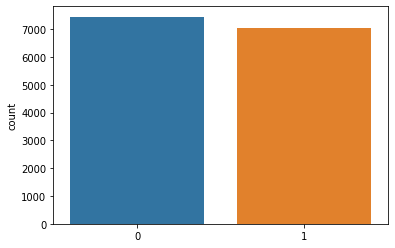

In [47]:
#checking the distribution of the target variable
sns.countplot(y_train)
plt.show()

In [48]:
#using RandomForestClassifier algorithm for modelling
from sklearn.ensemble import RandomForestClassifier #Random Forest


model_rf = RandomForestClassifier(n_estimators=210, random_state=3, max_features='auto')
model_rf.fit(X_train, y_train)


a = model_rf.predict(X_test)



from sklearn.metrics import classification_report
print('çlassification_report')
print(classification_report(a, y_test))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(a, y_test))

çlassification_report
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2880
           1       0.99      0.90      0.94      3335

    accuracy                           0.94      6215
   macro avg       0.94      0.95      0.94      6215
weighted avg       0.95      0.94      0.94      6215

[[2848   32]
 [ 324 3011]]


In [49]:
y_pred = model_rf.predict(X_test)

In [50]:
test_n = test_n[main_cols]

In [51]:
predictions = model_rf.predict(test_n)

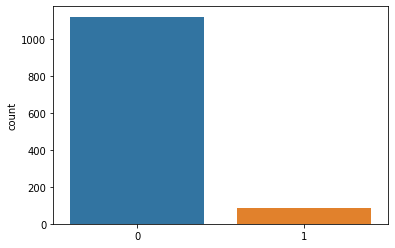

In [52]:
#checking the predictions of the predicted variables
sns.countplot(predictions)

In [53]:
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [54]:
sub_file = ss.copy()

In [55]:
sub_file.target = predictions

In [56]:
#making submissions
sub_file.to_csv("submission_file.csv", index=False)